In [22]:
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import display

import pandas as pd
import numpy as np
import json
import os

import DataMiner

pd.options.plotting.backend = "plotly"
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
O código-fonte deste notebook IPython é oculto por padrão para facilitar a leitura.
para mostrar/ocultar código fonte, clique <a href="javascript:code_toggle()">aqui</a>.''')

<img src="img/sthima_logo.jfif"
     alt="Markdown Monster icon"
     style="float: left; width:20%;" />
     
<img src="img/ATF.jfif"
     alt="Markdown Monster icon"
     style="width:40%;" />




# Score de Prospecção
____
>Este relatório apresenta todo o processo inicial para a classificação do sucesso ou falha ao contatar determinado CNPJ para a oferta de credito pela empresa ATF.Credit. Todo o processo utilizado para a criação de uma solução eficiente foi desenvolvido na linguagem de programação Python, utilizando como armazenamento o banco de dados não relacional MongoDB. Ao decorrer do relatório será explicado toda a metodología utilizada, as técnicas aplicadas e os passos futuros para o desenvolvimento de um modelo preciso e consitente.

> ## Definição do problema
> ___
> Como dito anteriormente, o objetivo deste trabalho é realizar uma classificação binaria. Para isso, foram disponibilizadas informações sobre **100 cnpj's** em formato de arquivo de texto. Sendo assim, o problema geral é definido, não apenas como um problema de classificação, mas também de limpeza e tratamento de dados, uma vez que os dados tem diversas origens e uma inconstancia de informações.
> ___
> ## 1. Tratamento Inicial
> A primeira etapa realizada no processo de solução do problema definido a cima, foi dada pela aquisição e interpretação dos txt's, seguido conversão dos arquivos em tabelas e do armazenamento em um banco de dados local e não relacional (**MongoDB**).
> ___
> ## 2. Limpeza dos Dados
> Os códigos apresentados a baixo fazem referência a limpeza dos dados e conversão das informações presentes nos txt's em parámetros que podem ser utilizadas no modelo de Aprendizado de Máquina (*Machine Learning*), uma vez que os dados ja foram convertidos em tabelas e armazenadas em um MongoDB.

In [23]:
dbm = DataMiner.DataBaseManager()

cursor = dbm.get_all_base()
df = pd.DataFrame()

for document in cursor:
    df = df.append(document, ignore_index=True)
    
df['Resultado'] = df['Resultado'].replace({'Indefinido':np.nan})

In [24]:
def count_word(name):
    count = 0
    for file_name in os.listdir('txtPuro/'):
        text = ""
        with open('txtPuro/'+file_name) as infile:
            for line in infile:
                text += line

        if text.count(name) >= 1:
            count+=1
            
    return count

In [25]:
null_columns = {}
null_columns['CINCO ULTIMAS'] = count_word('CINCO ULTIMAS')
null_columns['CONSULTAS A SERASA'] = count_word('CONSULTAS A SERASA')
null_columns['HISTORICO DE PAGAMENTOS - VISAO CEDENTE'] = count_word('HISTORICO DE PAGAMENTOS - VISAO CEDENTE')
null_columns['EVOLUCAO DE COMPROMISSOS - VISAO CEDENTE'] = count_word('EVOLUCAO DE COMPROMISSOS - VISAO CEDENTE')
null_columns['REFIN'] = count_word('REFIN')
null_columns['PEFIN'] = count_word('PEFIN')
null_columns['DIVIDA VENCIDA'] = count_word('DIVIDA VENCIDA')
null_columns['FALENCIA'] = count_word('FALENCIA')
null_columns['ACAO JUDICIAL'] = count_word('ACAO JUDICIAL')
null_columns['PROTESTO'] = count_word('PROTESTO')

null_columns = pd.Series(null_columns)

null_columns = null_columns.sort_values()

>> ### Tamanho da Base
>> Apesar de terem sido disponibilizados **100 txts**, só foram possivel ser interpretado de forma satisfatoria apenas **91**
>> ___
>> ### Parámetros Utilizados
>> Foram cedidos pela ATF.Credit a informação sobre 10 parámetros para serem utilizados no processo de predição. Entretanto, os dados disponibilizados apresentavam uma baixa quantidade desses parametros como pode ser viso no gráfico de barras abaixo:


In [26]:
# Use textposition='auto' for direct text
fig = go.Figure(data=[go.Bar(
            y=null_columns.keys(), x=null_columns.values,
            text = null_columns.values,
            textposition='auto',
            orientation='h'
        )])
fig.update_traces(textposition='outside')
fig.update_layout(title = "Total de txt's com cada informação ", template = 'plotly_white')
fig.show()

> ## 3. Parâmetros Utilizados
>> ### 3.1 Consultas Importântes
>> A tabela abaixo faz referência as empresas que consultaram determinado CNPJ. A partir dela, o parâmetro utilizado seria a quantidade de empresas do segmento *factoring* encontrado na coluna **EMPRESA** da tabela.
>>
>> O gráfico apresenta os valores encontrados no parâmetro utilizado

In [27]:
df_final = pd.DataFrame()
df_final['cnpj'] = df['cnpj']
df_final['y'] = df['Resultado']

In [28]:
pd.DataFrame(df['CINCO ULTIMAS CONSULTAS'].iloc[0])

,EMPRESA,QTD,DATA
0,NOVA AMERICA FACTORING LTDA,1,15/04/2019
1,REI ESPUMAS COM PLASTICOS COLCH,1,12/04/2019
2,RED SA,1,11/04/2019
3,CEF,2,10/04/2019
4,COOPERATIVA CEN ECON CRED MUTUO,1,09/04/2019


In [29]:
def consutlas_valores(line):
    
    try:
        aux_consultas = pd.DataFrame(line)
        count = 0

        for y in aux_consultas['EMPRESA']:
            if (y.find('RNX') >= 0) or (y.find('OPNIAO S/A') >= 0) or (y.find('FIDC') >= 0):
                count+=1

        return count
    except:
        return line

df_final['ConsultasCredito'] = df['CINCO ULTIMAS CONSULTAS'].apply(consutlas_valores)
fig = df_final['ConsultasCredito'].value_counts().plot.bar()
fig.update_layout(title = "Consultas Importântes", 
                  template = 'plotly_white', 
                  showlegend=False,
                  xaxis_title="Valores Encontrados",
                  yaxis_title="Quantidade"
                 )
fig.update_xaxes(type='category')
fig.show()

>> ### 3.2 Consultas Recentes
>> A tabela utilizada para a criação desse parametro pode ser vista abaixo
>>
>> Dado os ultimos 2 meses apresentados, caso a quantidade de consultas fosse maior que 30% da media o parâmetro seria definido como 1 e 0 caso contrario. Seria definido -1 caso a CNPJ nao apresentasse essa informação
>>
>> A distribuição dos dados pode ser visto no grafico de barras abaixo:

In [30]:
pd.DataFrame(df['REGISTRO DE CONSULTAS'].iloc[0])

,MES,QTD
0,MAR/19,10
1,FEV/19,19
2,JAN/19,25
3,DEZ/18,17
4,NOV/18,14
5,OUT/18,9
6,AGO/18,18
7,JUL/18,20
8,JUN/18,17
9,MAI/18,12


In [31]:
def consultas_recentes(line):
    try:
        aux_consultas = pd.DataFrame(line)
        aux_consultas['QTD'] = aux_consultas['QTD'].astype(int)
        if aux_consultas['QTD'].iloc[0] > (aux_consultas['QTD'].median() + aux_consultas['QTD'].median()*0.3)\
            or aux_consultas['QTD'].iloc[1] > (aux_consultas['QTD'].median() + aux_consultas['QTD'].median()*0.3):
            return 1
        else:
            return 0
    except:
        return -1
    
df_final['ConsultasRecentes'] = df['REGISTRO DE CONSULTAS'].apply(consultas_recentes)

fig = df_final['ConsultasRecentes'].value_counts().plot.bar()
fig.update_layout(title = "Consultas Recentes", 
                  template = 'plotly_white', 
                  showlegend=False,
                  xaxis_title="Valores Encontrados",
                  yaxis_title="Quantidade"
                 )
fig.update_xaxes(type='category')
fig.show()


>> ### 3.3 Total de Consultas
>> Utilizando a mesma tabela do parâmetro a cima, esse parâmetro é definido apenas pelo somatorio das consultas realizadas 
>>
>> A distribuição dos dados pode ser visto no grafico de caixa abaixo:

In [32]:
def total_consultas_recentes(line):
    try:
        aux_consultas = pd.DataFrame(line)
        aux_consultas['QTD'] = aux_consultas['QTD'].astype(int)
        return sum(aux_consultas['QTD'])
    except:
        return -1
    
df_final['Total_Consultas'] = df['REGISTRO DE CONSULTAS'].apply(total_consultas_recentes)
aux_plot = df_final['Total_Consultas'].value_counts()

In [33]:
v_plot = []
for i in aux_plot.keys():
    for j in range(aux_plot[i]):
        v_plot.append(i)

fig = go.Figure()
fig.add_trace(go.Box(
    y=v_plot,
    name='Total de Consultas',
))
fig.update_layout(title = "Total de Consultas", 
                  template = 'plotly_white', 
                  showlegend=False,
                  yaxis_title="Quantidade"
                 )
fig.show()

>> ### 3.4 Evolução de Compromissos 
>> A tabela utilizada para a criação desse parametro pode ser vista abaixo:
>>
>> O calculo desse parametro é feito tomando como base a coluna de **VENCIDOS** e **A VENCER**, caso exista algum valor em uma dessas colunas nas 3 primeiras linhas, o valor de **0.8** é atribuido ao parâmetros por cada linha com valor presente, caso as outras linhas apresentem valores nessas colunas, é atribuido **0.2**.
>>
>> A distribuição dos dados pode ser visto no grafico de barras abaixo:

In [42]:
pd.DataFrame(df['EVOLUCAO DE COMPROMISSOS - VISAO CEDENTE (VALORES EM R$)'].iloc[10])

,MES/ANO,VENCIDOS,A VENCER,TOTAL
0,12/19 A15,550 A 600,800 MIL A 900 MIL,800 MIL A 900 MIL
1,11/19 B3,"2,5 MIL A 3 MIL",800 MIL A 900 MIL,800 MIL A 900 MIL
2,10/19 B19,13 MIL A 15 MIL,400 MIL A 500 MIL,400 MIL A 500 MIL
3,09/19 B8,"5 MIL A 5,5 MIL",400 MIL A 500 MIL,500 MIL A 600 MIL
4,08/19,-------------------,500 MIL A 600 MIL,500 MIL A 600 MIL
5,07/19,-------------------,300 MIL A 400 MIL,300 MIL A 400 MIL
6,TOTAL C25,"3,5 MI A 4 MI",None,None


In [14]:
def convert_value(a):
    try:
        v = []
        for n in a.split(' '):
            if str.isnumeric(n):
                v.append(int(n))
        if len(v) > 0:
            return np.max(v)
        else:
            return a
    except:
        return a

def clear_consultas(aux_consultas):
    if aux_consultas['MES/ANO'].iloc[-1].count('TOTAL') >= 1:
        aux_consultas = aux_consultas.iloc[:-1]

    for c in aux_consultas.columns[1:]:
        r = []
        for i in aux_consultas[c]:
            if i.count('-')>2:
                r.append(np.nan)
            else:
                v = convert_value(i)
                
                r.append(float(str(v).replace('.','')))
        aux_consultas[c] = r
        
    return aux_consultas

def evolucao_cedente(line):
    try:

        aux_consultas = pd.DataFrame(line)
        aux_consultas.columns = ['MES/ANO','VENCIDOS','A VENCER','TOTAL']
        aux_consultas = clear_consultas(aux_consultas)
        score = 0

        for i in range(0,len(aux_consultas)):
            if (aux_consultas.iloc[i]['VENCIDOS'] > 0) or (aux_consultas.iloc[i]['A VENCER'] > 0):
                if i < 3:
                    score += 0.8
                else:
                    score += 0.2

        return score
    except:
        return -1

    

df_final['EvolucaoCompromissos'] = df['EVOLUCAO DE COMPROMISSOS - VISAO CEDENTE (VALORES EM R$)'].apply(evolucao_cedente)
aux_plot = df_final['EvolucaoCompromissos'].value_counts()
fig = go.Figure(data=[go.Bar(
            y=[round(i,4) for i in aux_plot.keys()], x=aux_plot.values,
            text = null_columns.values,
            textposition='auto',
            orientation = 'h'
            
        )])
fig.update_traces(textposition='outside')
fig.update_layout(title = "EVOLUCAO DE COMPROMISSOS - VISAO CEDENTE", template = 'plotly_white')
fig.update_yaxes(type='category')
fig.show()

>> ### 3.5 HISTORICO DE PAGAMENTOS
>> A tabela utilizada para a criação desse parametro pode ser vista abaixo:
>>
>> O calculo desse parametro é feito tomando como base 4 colunas e atribuindo um determinado valor ao parametro caso a coluna em questão apresente alguma informação, os valores atribuidos para cada coluna são:
>> * **8-15_QTD**: 0.3
>> * **16-30_QTD**: 0.5
>> * **31-60_QTD**: 0.7
>> * **+60_QTD**: 0.9
>>
>> A distribuição dos dados pode ser visto no grafico de caixa abaixo:

In [15]:
pd.DataFrame(df['HISTORICO DE PAGAMENTOS - VISAO CEDENTE'].iloc[10])

,MES/ANO,PONTUAL_QTD,PONTUAL_,8-15_QTD,8-15_%,16-30_QTD,16-30_%,31-60_QTD,31-60_%,+60_QTD,+60_%,A_VISTA_QTD,A_VISTA_%
0,NOV/19,300 MIL A 400 MIL,"93,00% A 95,00%","5,5 MIL A 6 MIL","1,00% A 3,00%","5 MIL A 5,5 MIL","1,00% A 3,00%",10 MIL A 13 MIL,"1,00% A 3,00%",None,None,None,None
1,OUT/19,300 MIL A 400 MIL,"95,00% A 97,00%",None,None,10 MIL A 13 MIL,"3,00% A 5,00%",None,None,None,None,None,None
2,SET/19,300 MIL A 400 MIL,"97,00% A 100,00%",None,None,"8,5 MIL A 9 MIL","1,00% A 3,00%",None,None,None,None,None,None
3,AGO/19,100 MIL A 200 MIL,"93,00% A 95,00%",10 MIL A 13 MIL,"5,00% A 7,00%",None,None,None,None,None,None,None,None
4,JUL/19,"6 MIL A 6,5 MIL","97,00% A 100,00%",None,None,None,None,None,None,None,None,None,None


In [16]:
def calculate_historico(line):
    
    try:
        aux_consultas = pd.DataFrame(line)
    except:
        return -1
    
    if len(aux_consultas) <=0 :
        return -1
    
#     print(aux_consultas)
    score_count = 0
    for i,j in aux_consultas.iterrows():
        if not(j['8-15_QTD'] is None):
            score_count+=0.3
            
        if not(j['16-30_QTD'] is None):
            score_count+=0.5
            
        if not(j['31-60_QTD'] is None):
            score_count+=0.7
            
        if not(j['+60_QTD'] is None):
            score_count+=0.9
            
    return score_count

df_final['HistoricoPagamentos'] = df['HISTORICO DE PAGAMENTOS - VISAO CEDENTE'].apply(calculate_historico)
aux_plot = df_final['HistoricoPagamentos'].value_counts()

In [17]:
v_plot = []
for i in aux_plot.keys():
    for j in range(aux_plot[i]):
        v_plot.append(i)

fig = go.Figure()
fig.add_trace(go.Box(
    y=v_plot,
    name='HistoricoPagamentos',
))
fig.update_layout(title = "HistoricoPagamentos", 
                  template = 'plotly_white', 
                  showlegend=False,
                  yaxis_title="Quantidade"
                 )
fig.show()

> ## 4. Analize inicial
> ___
> Após o processo de limpeza e tratamento, é obtido a tabela abaixo com um total de **84 linhas** e **7 colunas**, com os valores encontrados pela busca de parâmetros a cima. Vale salientar que na coluna **y** é onde encontra-se o resultado ao contatar o cliente, sendo **1: Sucesso** e **0: Falha**
> 
> Uma amostra da tabela pode ser vista abaixo

In [18]:
df_final['y'] = df_final['y'].replace({'Insucesso':0, 'Sucesso':1})
df_final = df_final[df_final['y'].notnull()]

In [19]:
df_final.head()

,cnpj,y,ConsultasCredito,ConsultasRecentes,Total_Consultas,EvolucaoCompromissos,HistoricoPagamentos
0,95.816.963/0001-74,0.0,0.0,0,187,4.6,-1.0
1,03.943.986/0001-21,1.0,0.0,0,207,2.6,0.0
2,13.056.177/0003-13,0.0,0.0,0,878,4.4,-1.0
3,78.099.777/0001-42,1.0,0.0,1,561,4.4,-1.0
4,00.325.400/0001-77,0.0,0.0,0,177,4.6,-1.0


>> ### Distribuição dos valores
>> O gráfico abaixo apresenta a distribuição dos valores em formato de um grafico de pontos, levando em consideração o Historico de Pagamentos e o número Total de Consultas. 

In [244]:
fig = go.Figure()

df_aux = df_final[df_final['y'] == 1]
fig.add_trace(go.Scatter(
    x=df_aux['HistoricoPagamentos'],
    y=df_aux['Total_Consultas'],
    marker=dict(size=5),
    mode="markers",
    name="Sucesso",
))

df_aux = df_final[df_final['y'] == 0]
fig.add_trace(go.Scatter(
    x=df_aux['HistoricoPagamentos'],
    y=df_aux['Total_Consultas'],
    marker=dict(size=5),
    mode="markers",
    name="Insucesso",
))


fig.update_layout(template = 'plotly_white',
                  xaxis_title="Historico de Pagamentos",
                  yaxis_title="Total de Consultas")
                  


fig.show()

>> A partir de uma breve analise do gráfico a cima é possivel identificar algumas carateristicas nos dados, sendo elas:
>> * A maioria dos casos de insucesso não apresentam um Historico de Pagamentos, sendo representado por **-1**
>> * Grande quantidade dos casos de sucesso se encontrar com menos de 600 consultas e com Historico de pagamentos maior ou igual a zero

> ## 5. Classificação CNPJ
> ___
> Nessa etapa do processo, foi realizado a classificação entre sucesso(**1**) e falha(**0**) utilizando os **84** dados obtidos após todo o processo de captura e limpeza. Sendo assim, o processo de treinamento de um modelo de *Machine Learning* foi realizado dividindo a base em 75% para treino (**63 dados**) e 25% para teste (**21 dados**)

> Cada valor encontrado no conjunto de dados representando a classificação, nós chamamos de **classe**. Sendo assim, para um processo de Aprendizado de Máquina satisfatorio é necessário que as classes estejam minimamente divididas entre os conjuntos de treino e de teste. Essa divisão pode ser visualizada no gráfico abaixo:


In [245]:
import matplotlib.pyplot as plt  
import random

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [246]:
random_state = np.random.RandomState(14)
df_final = df_final.reset_index(drop = True)

X_train, X_test, y_train, y_test = train_test_split(df_final.drop(columns = ['y']), \
                                                    df_final['y'], \
                                                    test_size=0.25, random_state = random_state)

In [247]:
from plotly.subplots import make_subplots
labels = ['Sucesso','Falha']
values = [12, 9]

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=labels, values=[len(y_test[y_test == 1]), len(y_test[y_test == 0])], \
                     name="Teste"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=[len(y_train[y_train == 1]), len(y_train[y_train == 0])], \
                     name="Treino"),
              1, 1)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Divisão das Classes",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Treino', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Teste', x=0.82, y=0.5, font_size=20, showarrow=False)])

fig.show()

>> ### 5.1 *Support Vector Classification*
>> Após alguns testes realizados, o melhor algoritmo encontrado foi o *Support Vector Classification*(SVC) com a otimização do gradiente descendente estocástico. O SVC é uma variação do *Support Vector Machine* que é um algoritmo supervisionado que através de operações vetoriais para aumento de dimensionalidade tenta criar um hiperplano que melhor separe os dados.
>> O funcionamento do algoritmo pode ser melhor entendido atraves do giff abaixo

>>![Alt Text](img/svm.gif)

>> ### 5.2 Métricas Utilizadas
>> Para Validação do modelo foram utilizadas 3 metricas, sendo elas:
>> * ***Accuracy***: Indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente.
>> * ***Precisçao***: Indica dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas;
>> * ***Recal(Revocação)***: Indica dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas;
>> O calculo de cada metrica é simples e pode ser visto abaixo, onde cada variavel é oriunda da matriz de confusão explicada logo em seguida 

>> 
>> ![Alt Text](img/Metricas.png)
>> ___
>> **5.2.1 Matriz de Confusão**
>>
>> A matriz de confusão indica a quantidade de erros e acertos do modelo, comparando com o resultado esperado:
>> ![Alt Text](img/matriz.png)
>>___


In [248]:
sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=100, tol=0.0001, loss="hinge", random_state = 0))
sgd.fit(X_train.drop(columns = ['cnpj']), y_train)
y_result = sgd.predict(X_test.drop(columns = ['cnpj']))

sgd_ac = accuracy_score(y_test, y_result)
sgd_pr = precision_score(y_test, y_result, average='weighted')
sgd_rc = recall_score(y_test, y_result)


> # 6. Resultados Obtidos

In [249]:
from IPython.display import display, Markdown, Latex
display(Markdown('>> * Accuracy: **'+"{:.2f}".format(sgd_ac)+'** \n >> * Precisão: **'+"{:.2f}".format(sgd_pr)+'** \n >> * Recal: **'+"{:.2f}".format(sgd_rc)+'7**'))

>> * Accuracy: **0.90** 
 >> * Precisão: **0.92** 
 >> * Recal: **0.837**

>> **Matriz de Confusão:**

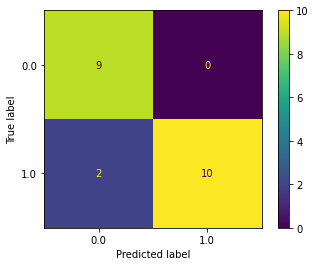

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

confusion_matrix(y_test, y_result)
plot_confusion_matrix(sgd, X_test, y_test)  
plt.show()  

In [27]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve

# from sklearn.metrics import average_precision_score
# average_precision = average_precision_score(y_test, y_result)
# print(average_precision)

# plot_precision_recall_curve(sgd, X_test, y_test)  
# plt.show()  

> # 7. Próximos Passos
> Como mostrado nesse trabalho, já é possivel valdiar a aplicabilidade de uma solução. Entretanto, apesar dos bons resultados alcançados nesse trabalho, vale salientar que todos os testes foram realizados em um conjunto de dados pequenos que não refletem a realidade por completo. Sendo assim, os proximos passos devem ser a captura de mais dados consistentes, juntamente com a analise de novos parametros para conseguir resultados cada vez mais confiaveis. Além disso, uma proxima etapa tambem deve ser a transformação de uma classificação binaria em uma regressão para um score entre 0 e 100, atraves de algoritmos de aprendizado não supervisionados.

<!-- > # 8. Teste Local -->

In [20]:
# X_test_aux = X_test
# X_test_aux['Resultado'] = y_test
# X_test_aux.head()

In [21]:
# import ipywidgets as widgets

# X_test.columns 

# cc = widgets.BoundedFloatText(
#     value=0,
#     min=0,
#     max=1,
#     step=1,
# )


# cr = widgets.BoundedFloatText(
#     value=0,
#     min=0,
#     max=1,
#     step=1,
# )

# tc = widgets.BoundedFloatText(
#     value=0,
#     min=0,
#     max=900,
#     step=1,
# )

# ec = widgets.BoundedFloatText(
#     value=-1,
#     min=-1,
#     max=6,
#     step=0.1,
# )


# hp = widgets.BoundedFloatText(
#     value=-1,
#     min=-1,
#     max=30,
#     step=0.1,
# )


# from IPython.display import clear_output

# display(Markdown('## Consultas de Credito:'))
# display(cc)

# display(Markdown('## Consultas Recentes:'))
# display(cr)

# display(Markdown('## Total de Consultas:'))
# display(tc)

# display(Markdown('## Evolucao de Compromissos:'))
# display(ec)

# display(Markdown('## Histórico de Compromissos:'))
# display(hp)

# button = widgets.Button(description="Classificar CNPJ")
# output = widgets.Output()

# def on_button_clicked(b):
#     with output:
#         clear_output(wait=True)
#         result = cc.value
        
#         new_data = {'ConsultasCredito':cc.value, 'ConsultasRecentes':cr.value, 'Total_Consultas':tc.value,
#        'EvolucaoCompromissos':ec.value, 'HistoricoPagamentos':hp.value}
        
#         df_pre = pd.DataFrame([new_data])
#         display(Markdown('___'))
#         display(Markdown('## Dados Utilizados:'))
#         display(df_pre)
        
#         if int(sgd.predict(df_pre)[0]):
#             result = 'Sucesso'
#         else:
#             result = 'Falha'
#         display(Markdown('___'))
#         display(Markdown('* **Resultado:** '+result))

    
    
# result = button.on_click(on_button_clicked)

# display(button, output)
